In [71]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

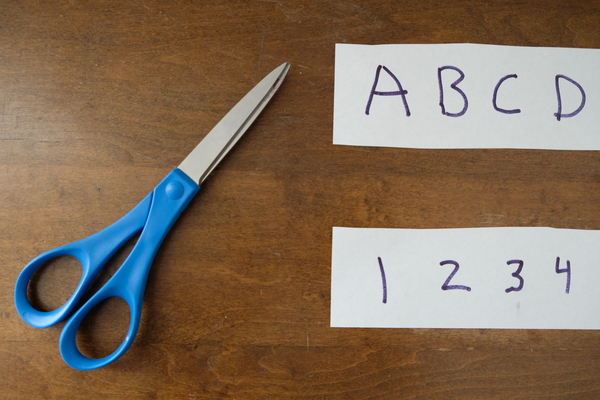

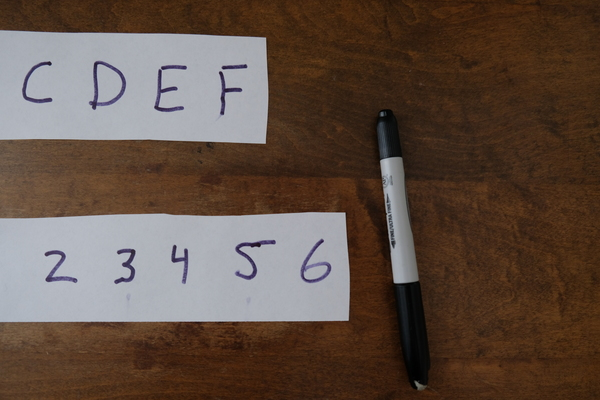

In [72]:
reference_image = cv2.imread('reference.jpg')
reference_image_gray = cv2.cvtColor(reference_image, cv2.COLOR_RGB2GRAY)

candidate_image = cv2.imread('candidate.jpg')
candidate_image_gray = cv2.cvtColor(candidate_image, cv2.COLOR_RGB2GRAY)



cv2_imshow(candidate_image)
print("")
cv2_imshow(reference_image)


##Feature Extraction (SIFT)


In [73]:
sift_object = cv2.SIFT_create()

(keypoints_reference, descriptors_reference) = sift_object.detectAndCompute(reference_image_gray, None)
(keypoints_candidate, descriptors_candidate) = sift_object.detectAndCompute(candidate_image_gray, None)

In [74]:
print(" no of candidate features = " , len(keypoints_candidate))
print(" no of reference features = " , len(keypoints_reference))

 no of candidate features =  259
 no of reference features =  219


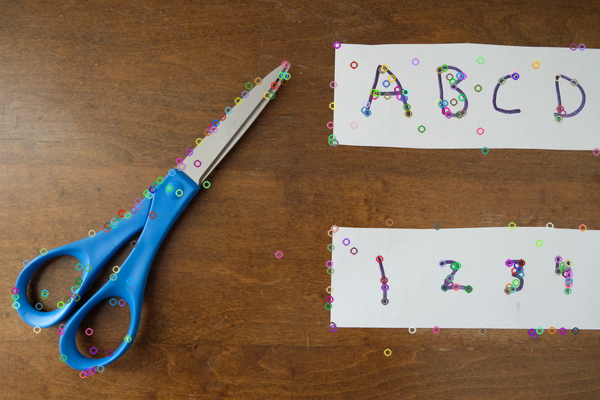

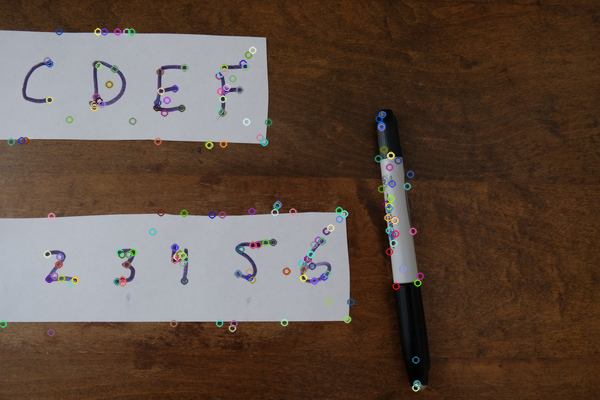

In [75]:
cv2_imshow(cv2.drawKeypoints(candidate_image, keypoints_candidate, None      ) )
print("")
cv2_imshow(cv2.drawKeypoints(reference_image, keypoints_reference, None) )

##Matching the descriptors (Brute force)

In [76]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck= True)

best_matches = bf.match(descriptors_candidate,descriptors_reference)

matches = sorted(best_matches, key = lambda x:x.distance)
print("matches:", len(matches))

matches: 92


In [77]:
# ratio = 0.75

# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck= False)
# best_matches_knn = bf.knnMatch(descriptors_reference,descriptors_candidate, k=2)
# print("Raw matches (knn):", len(best_matches_knn))
# matches = []

# for m,n in best_matches_knn:
#   if m.distance < n.distance * ratio:
#       matches.append(m)
# print("matches (knn):", len(matches))

In [78]:
len(matches)

92

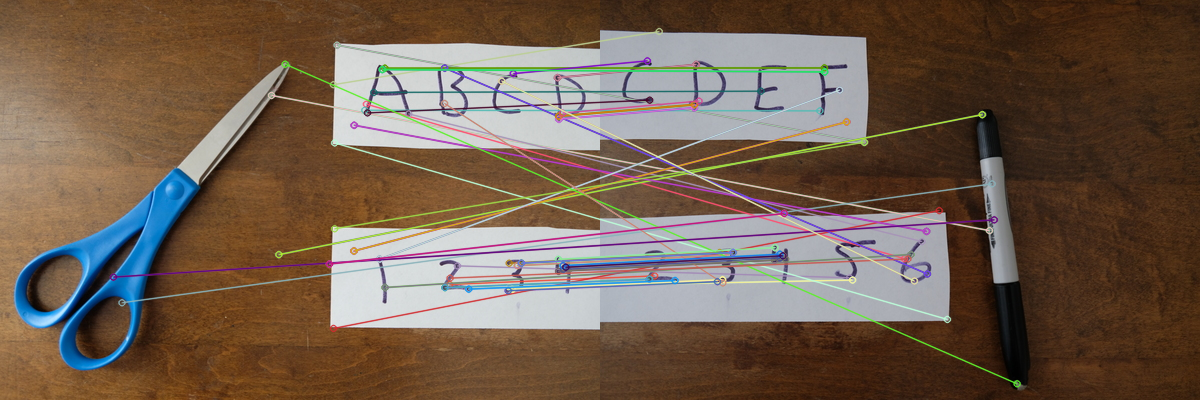

In [79]:
mapped_keypoints_image = cv2.drawMatches( candidate_image ,keypoints_candidate,reference_image, keypoints_reference, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2_imshow(mapped_keypoints_image)

##Calculate Homography

In [80]:
keypoints_reference_np = np.float32([keypoint.pt for keypoint in keypoints_reference])
keypoints_candidate_np = np.float32([keypoint.pt for keypoint in keypoints_candidate])

matched_keypoints_reference_np = np.float32([keypoints_reference_np[m.trainIdx] for m in matches])
matched_keypoints_candidate_np = np.float32([keypoints_candidate_np[m.queryIdx] for m in matches])

In [81]:
(homography, status) = cv2.findHomography(matched_keypoints_reference_np, matched_keypoints_candidate_np, cv2.RANSAC, ransacReprojThreshold=4)

In [82]:
print(homography)

[[1.07621726e+00 4.23110740e-02 3.87843396e+02]
 [8.64356506e-02 9.86348122e-01 1.31705674e+01]
 [2.63987806e-04 1.72538534e-05 1.00000000e+00]]


##Combine Images

In [83]:
width = candidate_image.shape[1] + reference_image.shape[1]
height = max(candidate_image.shape[0], reference_image.shape[0])
print('Width:', width)
print('height:', height)

Width: 1200
height: 400


In [84]:
result = cv2.warpPerspective(reference_image, homography, (width, height))
result[0:candidate_image.shape[0], 0:candidate_image.shape[1]] = candidate_image

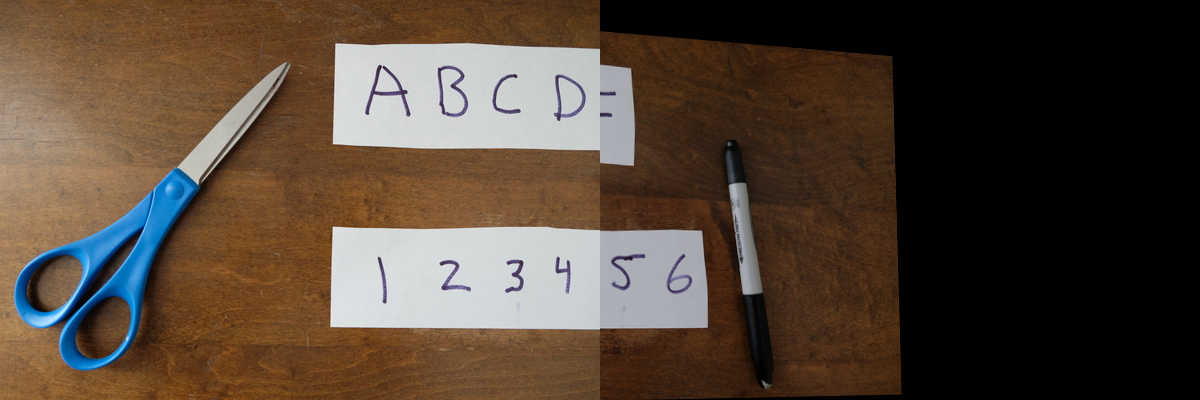

In [85]:
cv2_imshow(result)

## 1.Define metric which could be utilized for stitching two pairs.

The primary measure for stitching images involves the number and quality of matched features. This entails identifying key visual elements in both images and ensuring they align well. Additionally, the accuracy of the transformation between the images, often represented by the homography matrix, is crucial.

I have defined three metrics mean square error, Cross-Correlation and Feature Matching Score. These metrics can be used to assess the quality of the stitch


 To calculate the Mean Square Error

In [86]:
height, width = candidate_image_gray.shape
warped_reference_image = cv2.warpPerspective(reference_image_gray, homography, (width, height))


def crop_image(image):
    height, width = image.shape[:2]
    for y in range(height):
        for x in range(width):
            if image[y, x] != 0:
                return x
    return None
coord = crop_image(warped_reference_image)
cropped_reference_image = warped_reference_image[:, coord:]


crop_width = cropped_reference_image.shape[1]
cropped_candidate_image = candidate_image_gray[:, candidate_image_gray.shape[1]-crop_width:]

# cv2_imshow(cropped_reference_image)
# cv2_imshow(cropped_candidate_image)

mse = np.mean((cropped_reference_image - cropped_candidate_image) ** 2)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 107.83266431924882


To calculate  Cross-Correlation, Feature Matching Score

In [87]:
correlation = cv2.matchTemplate(reference_image_gray, candidate_image_gray, cv2.TM_CCOEFF_NORMED)
cross_correlation = np.max(correlation)
print('Cross-Correlation:', cross_correlation)


fm_score = len(matches) / min(len(keypoints_reference), len(keypoints_candidate))
print('Feature Matching Score:', fm_score)



Cross-Correlation: -0.15269293
Feature Matching Score: 0.4200913242009132


# 2. If the image were to be smoothed by a low pass filter, how would the stitching parameters value change?

Applying a low-pass filter to smooth images can somrtimes enhance feature detection and matching by reducing the noise. However, if it is blurred more, it may alter the feature characteristics like scale and orientation. Also the parameters for feature matching and homography estimation may need some adjustment to fit the smoother image.


# 3. Define stitching quality

Stitching quality depends on many key factors like
* The stitched panorama should demonstrate smooth transitions between the images.
* A high-quality stitched image should not have any visible seams, distortion, or misalignment.
* It should maintain consistent color and exposure across the whole stitched image.

## Using Inbuilt Stitcher Class from OpenCV

In [1]:
stitcher = cv2.Stitcher_create()
status, result2 = stitcher.stitch([ candidate_image, reference_image])
cv2_imshow(result2)

NameError: name 'cv2' is not defined

## Using inbuilt Stitcher function from Stitcher

In [68]:
pip install stitching

In [487]:
from stitching import Stitcher
stitcher = Stitcher()



In [488]:
stitcher = Stitcher(detector="sift", confidence_threshold=0.2)

result3 = stitcher.stitch([ candidate_image,reference_image])

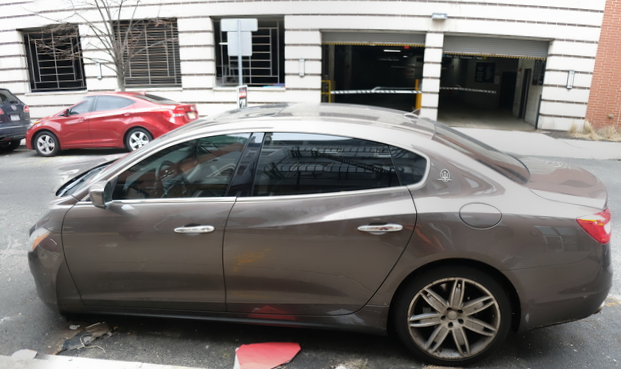

In [489]:
cv2_imshow(result3)